<a href="https://colab.research.google.com/github/navaneethsdk/Data-Driven-Astronomy/blob/master/Data_driven_Astronomy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***MEAN STACKING***

0.018398113548755646


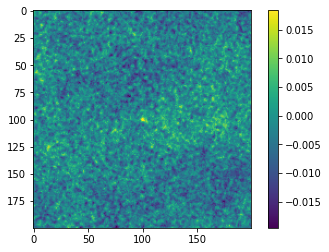

In [ ]:
# Write your mean_fits function here:
from astropy.io import fits
import numpy as np
def mean_fits(lis):
  sum=0
  for file in lis:
    hdulist = fits.open(file)
    data = hdulist[0].data
    arr = np.array(data)
    sum = sum + arr
     
  return sum/len(lis)



if __name__ == '__main__':
  
  # Test your function with examples from the question
  data  = mean_fits(['image0.fits', 'image1.fits', 'image2.fits'])
  print(data[100, 100])

  # You can also plot the result:
  import matplotlib.pyplot as plt
  plt.imshow(data.T, cmap=plt.cm.viridis)
  plt.colorbar()
  plt.show()

(14, 125)
Filename: image2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (200, 200)   float64   


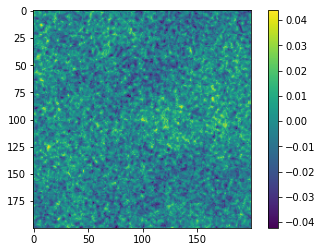

In [ ]:
# Write your load_fits function here.
from astropy.io import fits
import numpy as np

def load_fits(file):
  hdulist = fits.open(file)
  data = hdulist[0].data
  arr = np.array(data)
  return (np.argmax(np.max(arr,axis=1)),np.argmax(np.max(arr,axis=0)))


if __name__ == '__main__':
  # Run your `load_fits` function with examples:
  bright = load_fits('image2.fits')
  print(bright)

  # You can also confirm your result visually:
  from astropy.io import fits
  import matplotlib.pyplot as plt

  hdulist = fits.open('image2.fits')
  hdulist.info()
  data = hdulist[0].data

  # Plot the 2D image data
  plt.imshow(data.T, cmap=plt.cm.viridis)
  plt.colorbar()
  plt.show()

 


In [ ]:
# Write your function median_FITS here:
import numpy as np
from astropy.io import fits
import time
def median_fits(lis):
  nlis=[]
  for file in lis:
    hdulist = fits.open(file)
    data = hdulist[0].data
    arr = np.array(data)
    nlis.append(arr)
  
  narr = np.vstack(tuple(nlis))
  narr = narr.reshape(len(nlis),nlis[0].shape[0],nlis[0].shape[1]) 
  
  start = time.perf_counter()
  median = np.median(narr , axis =0)
  seconds = time.perf_counter() - start
  
  return (median , seconds , (narr.nbytes)/1024)
# You can use this to test your function.
# Any code inside this `if` statement will be ignored by the automarker.
if __name__ == '__main__':
  # Run your function with first example in the question.
  result = median_fits(['image0.fits', 'image1.fits'])
  print(result[0][100, 100], result[1], result[2])
  
  # Run your function with second example in the question.
  result = median_fits(['image{}.fits'.format(str(i)) for i in range(3)])
  print(result[0][100, 100], result[1], result[2])

0.012338057160377502 0.004880167999999685 625.0
0.012338057160377502 0.003012311000020418 937.5


## ***MEDIAN STACKING***

In [ ]:
import time, numpy as np
from astropy.io import fits


def running_stats(filenames):
  '''Calculates the running mean and stdev for a list of FITS files using Welford's method.'''
  n = 0
  for filename in filenames:
    hdulist = fits.open(filename)
    data = hdulist[0].data
    if n == 0:
      mean = np.zeros_like(data)
      s = np.zeros_like(data)

    n += 1
    delta = data - mean
    mean += delta/n
    s += delta*(data - mean)
    hdulist.close()

  s /= n - 1
  np.sqrt(s, s)

  if n < 2:
    return mean, None
  else:
    return mean, s

def median_bins_fits(filenames, B):
  # Calculate the mean and standard dev
  mean, std = running_stats(filenames)
    
  dim = mean.shape # Dimension of the FITS file arrays
    
  # Initialise bins
  left_bin = np.zeros(dim)
  bins = np.zeros((dim[0], dim[1], B))
  bin_width = 2 * std / B 

  # Loop over all FITS files
  for filename in filenames:
      hdulist = fits.open(filename)
      data = hdulist[0].data

      # Loop over every point in the 2D array
      for i in range(dim[0]):
        for j in range(dim[1]):
          value = data[i, j]
          mean_ = mean[i, j]
          std_ = std[i, j]

          if value < mean_ - std_:
            left_bin[i, j] += 1
                
          elif value >= mean_ - std_ and value < mean_ + std_:
            bin = int((value - (mean_ - std_))/bin_width[i, j])
            bins[i, j, bin] += 1

  return mean, std, left_bin, bins


def median_approx_fits(filenames, B):
  mean, std, left_bin, bins = median_bins_fits(filenames, B)
    
  dim = mean.shape # Dimension of the FITS file arrays
    
  # Position of the middle element over all files
  N = len(filenames)
  mid = (N + 1)/2
	
  bin_width = 2*std / B
  # Calculate the approximated median for each array element
  median = np.zeros(dim)   
  for i in range(dim[0]):
    for j in range(dim[1]):    
      count = left_bin[i, j]
      for b, bincount in enumerate(bins[i, j]):
        count += bincount
        if count >= mid:
          # Stop when the cumulative count exceeds the midpointz
          break
      median[i, j] = mean[i, j] - std[i, j] + bin_width[i, j]*(b + 0.5)
      
  return median

if __name__ == '__main__':
  mean, std, left_bin, bins = median_bins_fits(['image0.fits', 'image1.fits', 'image2.fits'], 5)
  median = median_approx_fits(['image0.fits', 'image1.fits', 'image2.fits'], 5)
  print(median[100, 100])

0.014199583324194326
